In [172]:
import time, csv
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

from random import shuffle

# Preprocessing data

In [173]:
train_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TRAIN"
test_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TEST"

In [174]:
train_data, train_label = [], []
with open(train_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    train_data.append(row[1:])
    train_label.append(row[0])
      
test_data, test_label = [], []
with open(test_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    test_data.append(row[1:])
    test_label.append(row[0])
      

In [175]:
# LENGTH = np.shape(train_data)[1]
LENGTH = 50
TRAIN_ALL_ROWS = np.shape(train_data)[0]
TRAIN_ROWS = 10
TEST_ALL_ROWS = np.shape(test_data)[0]
TEST_ROWS = 10

label_1 = 1
label_2 = 2

## train data

In [176]:
train_data = np.array(train_data, np.float32)
train_label = np.array(train_label, np.float32)
train_label = np.where(train_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
train_data = train_data[index_list]
train_label = train_label[index_list]

train_data = train_data[:TRAIN_ROWS, :LENGTH]
train_label = train_label[:TRAIN_ROWS]
train_label = train_label.reshape(-1, 1)

## test data

In [177]:
test_data = np.array(test_data, np.float32)
test_label = np.array(test_label, np.float32)
test_label = np.where(test_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
test_data = test_data[index_list]
test_label = test_label[index_list]

test_data = test_data[:TEST_ROWS, :LENGTH]
test_label = test_label[:TEST_ROWS]
test_label = test_label.reshape(-1, 1)

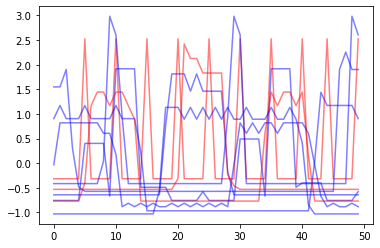

In [178]:
for i in range(TRAIN_ROWS):
  plt.plot(train_data[i].ravel(), 'b' if train_label[i] == 1 else 'r', alpha=0.5)
plt.show()

In [179]:
# batch = int(np.shape(train_x)[0] / 2)
batch = TRAIN_ROWS
iter = 5
lr = 0.01
gamma = 1.8

In [180]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [181]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [182]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

kernel = tf.exp(-tf.multiply(G, dtw_distances))

In [183]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [184]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [185]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [186]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [187]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(TRAIN_ROWS, size=batch, replace=False)
  rand_x = train_data[rand_index]
  rand_y = train_label[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.8
loss: -1.5364823
time : 4.242424011230469
Step #2
accuracy : 1.0
loss: -1.5746374
time : 3.292642831802368
Step #3
accuracy : 0.9
loss: -1.6112814
time : 3.402111053466797
Step #4
accuracy : 0.8
loss: -1.6464748
time : 4.58695912361145
Step #5
accuracy : 0.9
loss: -1.6802747
time : 3.9463508129119873
Total time : 19.47123122215271


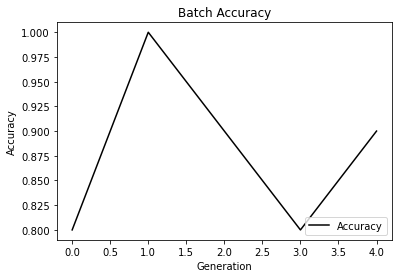

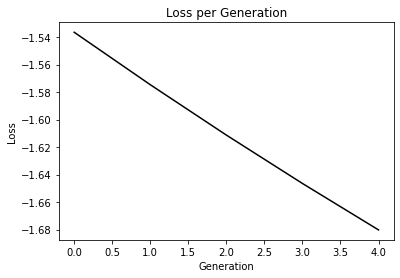

In [188]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [189]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data
                      })

print(test_preds)
print(test_label)

[[-1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]]
[[-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]]


In [190]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data,
                          test_Y: test_label
                      })
print(test_acc)


0.4


## Influence function

### Gradient for target data

In [26]:
inf_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_X], Tout=[tf.float32 for i in range(batch)])
inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))

In [27]:
inf_first_term = tf.reduce_sum(B)
inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))
inf_grad_op = tf.gradients(inf_loss, [B])
inf_hess_op = tf.hessians(inf_loss, [B])

In [28]:
test_index = 1

In [31]:
inf_target_grad = sess.run(inf_grad_op, feed_dict={
  X: train_x[rand_index],
  Y: train_y[rand_index],
  inf_X: [test_x[test_index]]
})

inf_hess = sess.run(inf_hess_op, feed_dict={
  X: train_x[rand_index],
  Y: train_y[rand_index],
  inf_X: train_x
})

inf_hess = np.squeeze(inf_hess)
inf_inv_hess = np.linalg.inv(inf_hess)

In [32]:
infs = []

for i in range(len(rand_index)):
  inf_train_grad = sess.run(inf_grad_op, feed_dict={
    X: train_x[rand_index],
    Y: train_y[rand_index],
    inf_X: [train_x[rand_index[i]]]
  })

  inf_train_grad = np.squeeze(inf_train_grad)
  z_hess_grad = np.matmul(-inf_inv_hess, inf_train_grad)

  inf_val = np.matmul(inf_train_grad, z_hess_grad)
  infs.append((rand_index[i], inf_val))

In [33]:
infs = sorted(infs, key=lambda x: x[1])

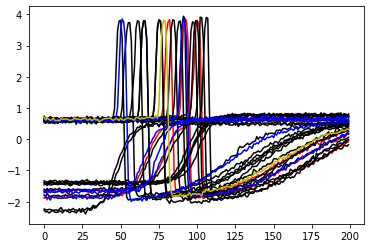

In [35]:
for i in range(len(infs)):
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 27:
    color = 'b'

  plt.plot(train_x[infs[i][0]], color)

plt.plot(test_x[test_index], 'y')
plt.show()
